# Doubly Convolutional Neural Networks

Replication of the filter correlation results obtained on AlexNet and VGGNet(19 layers).

In [4]:
import sys
sys.path.append('../src/')

In [5]:
import h5py
import numpy as np
import heapq
import matplotlib.pyplot as plt
%matplotlib inline
from filters_correlation import avg_max_k_translation_correlation, k_translation_correlation

In [6]:
# Load weights
# AlexNet weights : https://github.com/heuritech/convnets-keras
# http://files.heuritech.com/weights/alexnet_weights.h5
alexnet_weights = '../weights/alexnet_weights.h5'
# get first layer filters learned by AlexNet
WAlex = []
with h5py.File(alexnet_weights, 'r') as f:
    WAlex.append(np.array(f['conv_1']['conv_1_W']))
    WAlex.append(np.array(f['conv_2_1']['conv_2_1_W']))
    WAlex.append(np.array(f['conv_2_2']['conv_2_2_W']))
    WAlex.append(np.array(f['conv_3']['conv_3_W']))
    WAlex.append(np.array(f['conv_4_1']['conv_4_1_W']))
    WAlex.append(np.array(f['conv_4_2']['conv_4_2_W']))
    WAlex.append(np.array(f['conv_5_1']['conv_5_1_W']))
    WAlex.append(np.array(f['conv_5_2']['conv_5_2_W']))

In [7]:
# Load weights
# VGGNet 19 weights : https://github.com/heuritech/convnets-keras
# http://files.heuritech.com/weights/vgg19_weights.h5
vggnet_weights = '../weights/vgg19_weights.h5'
# get first layer filters learned by VGGNEt
WVGG = []
with h5py.File(vggnet_weights, 'r') as f:
    WVGG.append(np.array(f['conv1_1']['conv1_1_W']))
    WVGG.append(np.array(f['conv1_2']['conv1_2_W']))
    WVGG.append(np.array(f['conv2_1']['conv2_1_W']))
    WVGG.append(np.array(f['conv2_2']['conv2_2_W']))
    WVGG.append(np.array(f['conv3_1']['conv3_1_W']))
    WVGG.append(np.array(f['conv3_2']['conv3_2_W']))
    WVGG.append(np.array(f['conv3_3']['conv3_3_W']))
    WVGG.append(np.array(f['conv3_4']['conv3_4_W']))
    WVGG.append(np.array(f['conv4_1']['conv4_1_W']))
    WVGG.append(np.array(f['conv4_2']['conv4_2_W']))
    WVGG.append(np.array(f['conv4_3']['conv4_3_W']))
    WVGG.append(np.array(f['conv4_4']['conv4_4_W']))
    WVGG.append(np.array(f['conv5_1']['conv5_1_W']))
    WVGG.append(np.array(f['conv5_2']['conv5_2_W']))
    WVGG.append(np.array(f['conv5_3']['conv5_3_W']))
    WVGG.append(np.array(f['conv5_4']['conv5_4_W']))

In [56]:
def get_most_correlated_filter(n, k, W):
    lst = []
    
    nb_filters, _, _, _ = W.shape
    for i in range(nb_filters):
        k_trans_corr_list = []
        for j in range(nb_filters):
            if i == j:
                continue
            k_trans_corr_list.append((j, k_translation_correlation(k, W[i], W[j])))
        
        n_most_corr = heapq.nlargest(n, k_trans_corr_list, key=lambda x: x[1])
        most_corr_avg = 0.
        for k in range(n):
            most_corr_avg += n_most_corr[k][1]
        most_corr_avg /= n        
        lst.append((i,n_most_corr, most_corr_avg))
    
    lst.sort(key=lambda x: x[2], reverse=True)
            
    return lst
print WAlex[0].shape

(96, 3, 11, 11)


In [57]:
three_most_corr = get_most_correlated_filter(3, 3, WAlex[0])

Visualization of the 11×11 sized first layer filters learned by AlexNet. Each column shows a filter in the first row along with its three most 3-translation-correlated filters.

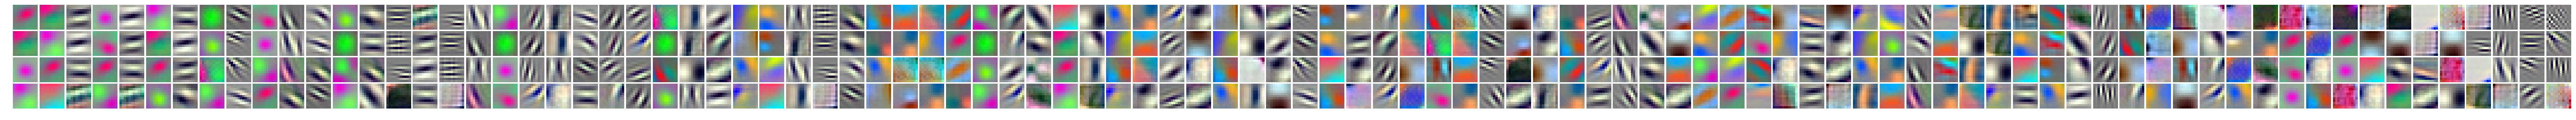

In [65]:
# Display n first filter of layer 1 and there 3 most 3-translation-correlated filters 
n = 96
plt.figure(figsize=(n,4))
plt.subplots_adjust(hspace=0.05, wspace=0.08)

for i in range(4):
    for j in range(n):
        filter_idx = three_most_corr[j][0] if i == 0 else three_most_corr[j][1][i-1][0]
        filter = np.moveaxis(WAlex[0][filter_idx], [0, 1, 2], [-1, -2, -3])
        min_ = filter.min()
        max_ = filter.max()
        filter = (filter-min_)/(max_-min_)
        plt.subplot(4, n, i*n+j+1)
        plt.axis('off')
        plt.imshow(filter)
plt.show()

Illustration of the averaged maximum 1-translation correlation
, together with the standard deviation, of each convolutional layer for AlexNet and the 19-layer VGGNet, respectively. For comparison, for each convolutional layer in each network, we generate a filter set with the same shape from the standard Gaussian distribution (the blue bars). For both networks, all the convolutional layers have averaged maximum 1-translation correlations that are significantly larger than their random counterparts.

In [40]:
def get_avg_std_all_layers(W):
    avg_rho_all_layers = np.zeros((2, len(W)))
    std_rho_all_layers = np.zeros((2, len(W)))
    k=1                              
    for i in range(len(W)):
        avg_rho_all_layers[0,i], std_rho_all_layers[0,i] = avg_max_k_translation_correlation(k, W[i])
        nb_samples, depth, width, height = W[i].shape
        rand_W = np.random.randn(nb_samples, depth, width, height)
        avg_rho_all_layers[1,i], std_rho_all_layers[1,i] = avg_max_k_translation_correlation(k, rand_W)
    return avg_rho_all_layers, std_rho_all_layers

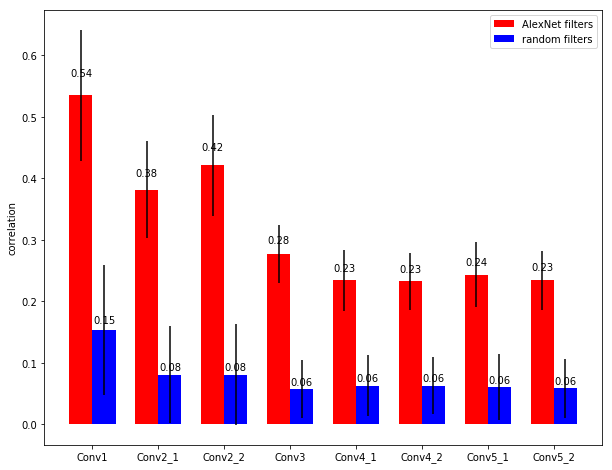

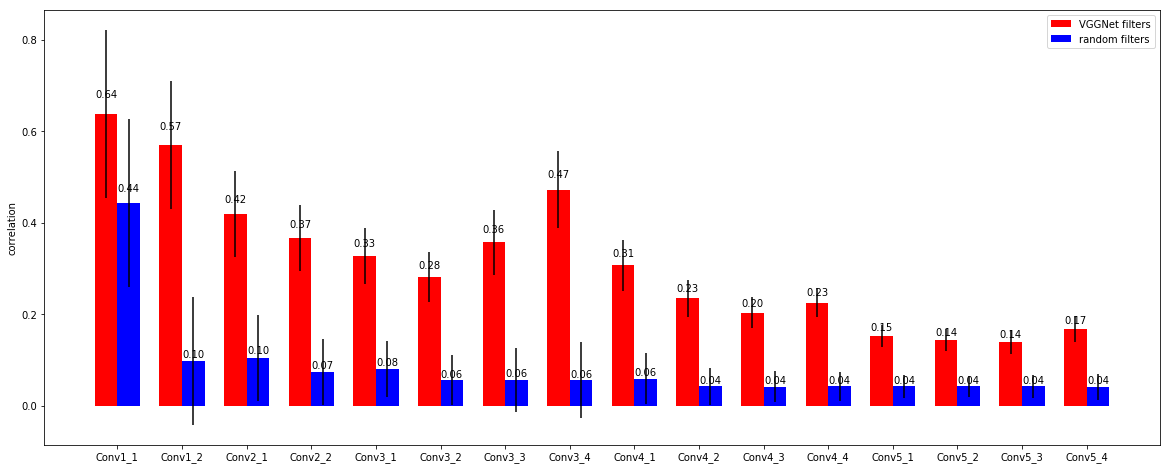

In [43]:
# This take few minutes to compute ...
# https://matplotlib.org/examples/api/barchart_demo.html
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '{0:.2f}'.format(height),
                ha='center', va='bottom')
## AlexNet
avg_rho_all_layers, std_rho_all_layers = get_avg_std_all_layers(WAlex)
width = 0.35
ind = np.arange(len(WAlex))

fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(ind, avg_rho_all_layers[0], width, color='r', yerr=std_rho_all_layers[0])
rects2 = ax.bar(ind+width, avg_rho_all_layers[1], width, color='b', yerr=std_rho_all_layers[0])
ax.set_ylabel('correlation')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Conv1', 'Conv2_1', 'Conv2_2', 'Conv3', 'Conv4_1', 'Conv4_2', 'Conv5_1', 'Conv5_2'))

ax.legend((rects1[0], rects2[0]), ('AlexNet filters', 'random filters'))
autolabel(rects1)
autolabel(rects2)
plt.show()

## VGG19
avg_rho_all_layers, std_rho_all_layers = get_avg_std_all_layers(WVGG)
ind = np.arange(len(WVGG))

fig, ax = plt.subplots(figsize=(20,8))
rects1 = ax.bar(ind, avg_rho_all_layers[0], width, color='r', yerr=std_rho_all_layers[0])
rects2 = ax.bar(ind+width, avg_rho_all_layers[1], width, color='b', yerr=std_rho_all_layers[0])
ax.set_ylabel('correlation')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Conv1_1', 'Conv1_2', 'Conv2_1',
                    'Conv2_2', 'Conv3_1', 'Conv3_2',
                    'Conv3_3', 'Conv3_4', 'Conv4_1',
                    'Conv4_2', 'Conv4_3', 'Conv4_4',
                    'Conv5_1', 'Conv5_2', 'Conv5_3',
                    'Conv5_4'))

ax.legend((rects1[0], rects2[0]), ('VGGNet filters', 'random filters'))
autolabel(rects1)
autolabel(rects2)
plt.show()